# Optimize data loading

* batching trajectories
* storing in BigQuery
* loading from BigQuery (in batches)

### Notebook config

In [1]:
# PREFIX = 'mabv1'
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


In [2]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"
DATA_PATH_KFP_DEMO       = "gs://rec-bandits-v2-hybrid-vertex-bucket/data/kfp_demo_data/u.data"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NA

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [34]:
import json
import time
import functools
import collections
import pickle as pkl
from pprint import pprint
from typing import Callable, Dict, List, Optional, TypeVar, Any

# logging
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage, bigquery

# tensorflow
import tensorflow as tf

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

In [57]:
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.bandits.policies import policy_utilities
from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.metrics import tf_metrics
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.trajectories import trajectory
from tf_agents import trajectories

from tf_agents.policies import py_tf_eager_policy
from tf_agents.trajectories import time_step as ts
from tf_agents.policies import policy_saver
from tf_agents.metrics import export_utils
from tf_agents.eval import metric_utils
from tf_agents.utils import common

In [6]:
import sys
sys.path.append("..")

# this repo
from src import train_utils as train_utils
from src import reward_factory as reward_factory
from src.data import data_utils as data_utils
from src.data import data_config as data_config
# from src.trainer import eval_perarm as eval_perarm
# from src.trainer import train_perarm as train_perarm
from src.agents import agent_factory as agent_factory
from src.networks import encoding_network as emb_features

In [7]:
# GPU
from numba import cuda 
import gc

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

### GCP clients

In [10]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# bigquery client
bqclient = bigquery.Client(project=PROJECT_ID,)

## Get data

In [11]:
EXAMPLE_GEN_GCS_PATH = data_config.EXAMPLE_GEN_GCS_PATH
GCS_DATA_PATH = f"{BUCKET_URI}/{EXAMPLE_GEN_GCS_PATH}"

print(f"GCS_DATA_PATH: {GCS_DATA_PATH}")

!gsutil ls $GCS_DATA_PATH

GCS_DATA_PATH: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/val/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/vocabs/


In [12]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

In [13]:
SPLIT = "train" # "train" | "val"

train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{EXAMPLE_GEN_GCS_PATH}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files = train_files[:1]
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils._parse_function)

# for x in train_dataset.batch(1).take(1):
#     pprint(x)

In [14]:
EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{EXAMPLE_GEN_GCS_PATH}/vocabs/{VOCAB_FILENAME}'
print(f"Downloading vocab...")

os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

filehandler = open(VOCAB_FILENAME, 'rb')
vocab_dict = pkl.load(filehandler)
filehandler.close()

# for key in vocab_dict.keys():
#     pprint(key)

Downloaded vocab from: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/vocabs/vocab_dict.pkl



## Get feature pre-processing embeddings

In [15]:
NUM_OOV_BUCKETS        = 1
GLOBAL_EMBEDDING_SIZE  = 8
MV_EMBEDDING_SIZE      = 8

BATCH_SIZE             = 3
EVAL_BATCH_SIZE        = 1
NUM_ACTIONS            = 2

NUM_GLOBAL_FEATURES = len(data_utils.USER_FEATURE_NAMES)     # 6
NUM_ARM_FEATURES    = len(data_utils.MOVIE_FEATURE_NAMES)    # 5
EXPECTED_GLOBAL_DIM  = GLOBAL_EMBEDDING_SIZE * NUM_GLOBAL_FEATURES
EXPECTED_PER_ARM_DIM = MV_EMBEDDING_SIZE * NUM_ARM_FEATURES

print(f"BATCH_SIZE           : {BATCH_SIZE}")
print(f"EVAL_BATCH_SIZE      : {EVAL_BATCH_SIZE}")
print(f"NUM_ACTIONS          : {NUM_ACTIONS}")
print(f"EXPECTED_GLOBAL_DIM  : {EXPECTED_GLOBAL_DIM}")
print(f"EXPECTED_PER_ARM_DIM : {EXPECTED_PER_ARM_DIM}")

BATCH_SIZE           : 3
EVAL_BATCH_SIZE      : 1
NUM_ACTIONS          : 2
EXPECTED_GLOBAL_DIM  : 48
EXPECTED_PER_ARM_DIM : 32


In [16]:
# test emb models
for i in range(1):
    
    iterator = iter(train_dataset.batch(1))
    data = next(iterator)

# data

In [17]:
embs = emb_features.EmbeddingModel(
    vocab_dict = vocab_dict,
    num_oov_buckets = NUM_OOV_BUCKETS,
    global_emb_size = GLOBAL_EMBEDDING_SIZE,
    mv_emb_size = MV_EMBEDDING_SIZE,
)

embs

In [18]:
test_globals = embs._get_global_context_features(data)

GLOBAL_DIM = test_globals.shape[1]            
# shape checks out at batch_dim, nactions, arm feats
print(f"GLOBAL_DIM: {GLOBAL_DIM}")

test_arms = embs._get_per_arm_features(data)

PER_ARM_DIM = test_arms.shape[1]            
# shape checks out at batch_dim, nactions, arm feats
print(f"PER_ARM_DIM: {PER_ARM_DIM}")

GLOBAL_DIM: 48
PER_ARM_DIM: 32


## Trajectory function

In [20]:
BIGQUERY_TMP_FILE = "tmp_bq.json"
BATCH_SIZE = 8

In [21]:
BIGQUERY_TABLE_NAME = f"test_mv_b{BATCH_SIZE}_g{GLOBAL_EMBEDDING_SIZE}_a{MV_EMBEDDING_SIZE}"
BQ_TABLE_REF = f"{PROJECT_ID}.{BIGQUERY_DATASET_NAME}.{BIGQUERY_TABLE_NAME}"

# Dataset parameters
TFRECORD_FILE = (
    f"{BUCKET_URI}/data/from_bq_test/{BIGQUERY_TABLE_NAME}.tfrecord"
)

print(f"BQ_TABLE_REF  : {BQ_TABLE_REF}")
print(f"TFRECORD_FILE : {TFRECORD_FILE}")

BQ_TABLE_REF  : hybrid-vertex.mvlens_rec_bandits_v2.test_mv_b8_g8_a8
TFRECORD_FILE : gs://rec-bandits-v2-hybrid-vertex-bucket/data/from_bq_test/test_mv_b8_g8_a8.tfrecord


## my trajectory function

In [22]:
from tf_agents.trajectories import trajectory

def my_trajectory_fn(element):
    
    """Converts a dataset element into a trajectory."""
    global_features = embs._get_global_context_features(element)
    arm_features = embs._get_per_arm_features(element)

    observation = {
        bandit_spec_utils.GLOBAL_FEATURE_KEY: global_features
    }
    reward = reward_factory._get_rewards(element)

    policy_info = policy_utilities.PerArmPolicyInfo(
        chosen_arm_features=arm_features,
    )
    return trajectory.single_step(
        observation=observation,
        action=tf.zeros_like(
            reward, dtype=tf.int32
        ),
        policy_info=policy_info,
        reward=reward,
        discount=tf.zeros_like(reward)
    )

In [23]:
for x in train_dataset.batch(BATCH_SIZE).take(1):
    test_traj = my_trajectory_fn(x)
    
print(f"traj.action.shape      : {test_traj.action.shape}") 
print(f"traj.discount.shape    : {test_traj.discount.shape}")
print(f"traj.reward.shape      : {test_traj.reward.shape}")
print(f"traj.observation.shape : {test_traj.observation['global'].shape}")

traj.action.shape      : (8,)
traj.discount.shape    : (8,)
traj.reward.shape      : (8,)
traj.observation.shape : (8, 48)


In [29]:
# test_traj

### build from trajectory for BQ

In [28]:
test_trajectory_dict = {
    "step_type": test_traj.step_type.numpy().tolist(),
    "observation": [{
        "observation_batch": batch
    } for batch in test_traj.observation['global'].numpy().tolist()],
    "chosen_arm_features": [{
        "chosen_arm_features_batch": batch
    } for batch in test_traj.policy_info.chosen_arm_features.numpy().tolist()],
    "action": test_traj.action.numpy().tolist(),
    "next_step_type": test_traj.next_step_type.numpy().tolist(),
    "reward": test_traj.reward.numpy().tolist(),
    "discount": test_traj.discount.numpy().tolist(),
}
# test_trajectory_dict

In [27]:
def build_dict_from_trajectory(
    trajectory : trajectories.Trajectory
) -> Dict[str, Any]:
    trajectory_dict = {
        "step_type": trajectory.step_type.numpy().tolist(),
        "observation": [
            {
                "observation_batch": batch
            } for batch in trajectory.observation['global'].numpy().tolist()
        ],
        "chosen_arm_features": [
            {
                "chosen_arm_features_batch": batch
            } for batch in trajectory.policy_info.chosen_arm_features.numpy().tolist()
        ],
        "action": trajectory.action.numpy().tolist(),
        "next_step_type": trajectory.next_step_type.numpy().tolist(),
        "reward": trajectory.reward.numpy().tolist(),
        "discount": trajectory.discount.numpy().tolist(),
    }
    return trajectory_dict

In [30]:
for x in train_dataset.batch(BATCH_SIZE).take(1):
    test_traj = my_trajectory_fn(x)
    test_trajectory_dict = build_dict_from_trajectory(test_traj)
    break

x

{'target_movie_genres': <tf.Tensor: shape=(8, 10), dtype=string, numpy=
 array([[b'Drama', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK'],
        [b'Comedy', b'Drama', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK', b'UNK'],
        [b'Comedy', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK', b'UNK'],
        [b'Drama', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK'],
        [b'Comedy', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK', b'UNK'],
        [b'Drama', b'Fantasy', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK', b'UNK'],
        [b'Action', b'Adventure', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK', b'UNK'],
        [b'Action', b'Thriller', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK', b'UNK']], dtype=object)>,
 'target_movie_id': <tf.Tensor: shape=(8,), dtype=string, numpy=
 array([b'1775',

In [31]:
# test_traj

In [32]:
# test_trajectory_dict

## load examples to BQ

### write to local file

In [35]:
with open(BIGQUERY_TMP_FILE, "w") as f:
    for example in train_dataset.batch(BATCH_SIZE).take(count=10):
        test_trajectories = my_trajectory_fn(example)
        _traj_dict = build_dict_from_trajectory(test_trajectories)
        f.write(json.dumps(_traj_dict) + "\n")
        # break

In [36]:
example

{'target_movie_genres': <tf.Tensor: shape=(8, 10), dtype=string, numpy=
 array([[b'Action', b'Adventure', b'Sci-Fi', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK', b'UNK', b'UNK'],
        [b'Comedy', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK', b'UNK'],
        [b'Action', b'Adventure', b'Drama', b'Sci-Fi', b'War', b'UNK',
         b'UNK', b'UNK', b'UNK', b'UNK'],
        [b'Comedy', b'Crime', b'Drama', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK', b'UNK'],
        [b'Mystery', b'Thriller', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK', b'UNK'],
        [b"Children's", b'Comedy', b'Fantasy', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK', b'UNK', b'UNK'],
        [b'Mystery', b'Thriller', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK', b'UNK'],
        [b'Action', b'Drama', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK', b'UNK']], dtype=object)>,
 'target_movie_id': <tf.Tensor: shape=(8,), dt

### load table from file

In [37]:
job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField("step_type", "INT64", mode="REPEATED"),
        bigquery.SchemaField(
            "observation",
            "RECORD",
            mode="REPEATED",
            fields=[
                bigquery.SchemaField("observation_batch", "FLOAT64",
                                     "REPEATED")
            ]),
        bigquery.SchemaField(
            "chosen_arm_features",
            "RECORD",
            mode="REPEATED",
            fields=[
                bigquery.SchemaField("chosen_arm_features_batch", "FLOAT64",
                                     "REPEATED")
            ]),
        bigquery.SchemaField("action", "INT64", mode="REPEATED"),
        bigquery.SchemaField("next_step_type", "INT64", mode="REPEATED"),
        bigquery.SchemaField("reward", "FLOAT64", mode="REPEATED"),
        bigquery.SchemaField("discount", "FLOAT64", mode="REPEATED"),
    ],
    source_format=bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
)

In [38]:
with open(BIGQUERY_TMP_FILE, "rb") as source_file:
    load_job = bqclient.load_table_from_file(
        source_file, BQ_TABLE_REF, job_config=job_config
    )

load_job.result()  # Wait for the job to complete.

LoadJob<project=hybrid-vertex, location=US, id=7aa424df-63d5-44af-a384-7ed981038edb>

## write TF Record

In [43]:
def _bytes_feature(tensor: tf.Tensor) -> tf.train.Feature:
    """
    Returns a `tf.train.Feature` with bytes from `tensor`.

    Args:
      tensor: A `tf.Tensor` object.

    Returns:
      A `tf.train.Feature` object containing bytes that represent the content of
      `tensor`.
    """
    value = tf.io.serialize_tensor(tensor)
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def build_example_from_bq(data_row: bigquery.table.Row) -> tf.train.Example:
    """
    Builds a `tf.train.Example` from `data_row` content.

    Args:
      data_row: 
        A `bigquery.table.Row` object that contains 7 pieces of data:
          `step_type`, `observation`, `chosen_arm_features`, `action`, `policy_info`,
          `next_step_type`,`reward`, `discount`. Each piece of data except `observation`
          and `chosen_arm_features` are 1D arrays; 
          `observation` is a 1D array of `{"observation_batch": 1D array}.`
          `chosen_arm_features` is a 1D array of `{"chosen_arm_features_batch": 1D array}.`

    Returns:
      A `tf.train.Example` object holding the same data as `data_row`.
    """
    feature = {
        "observation":
            _bytes_feature([
                observation["observation_batch"]
                for observation in data_row.get("observation")
            ]),
        "chosen_arm_features":
            _bytes_feature([
                arm_feats["chosen_arm_features_batch"]
                for arm_feats in data_row.get("chosen_arm_features")
            ]),
        "step_type":
            _bytes_feature(data_row.get("step_type")),
        "action":
            _bytes_feature(data_row.get("action")),
        "next_step_type":
            _bytes_feature(data_row.get("next_step_type")),
        "reward":
            _bytes_feature(data_row.get("reward")),
        "discount":
            _bytes_feature(data_row.get("discount")),
    }
    example_proto = tf.train.Example(
        features=tf.train.Features(feature=feature))
    return example_proto

In [44]:
bq_table = bqclient.get_table(BQ_TABLE_REF)
print(f"Got table: `{bq_table.project}.{bq_table.dataset_id}.{bq_table.table_id}`")
print("Table has {} rows".format(bq_table.num_rows))

table_row_iter = bqclient.list_rows(bq_table)

Got table: `hybrid-vertex.mvlens_rec_bandits_v2.test_mv_b8_g8_a8`
Table has 10 rows


In [45]:
def write_tfrecords(
    tfrecord_file: str,
    table: bigquery.table.RowIterator
) -> None:
    """
    Writes the row data in `table` into TFRecords in `tfrecord_file`.

    Args:
      tfrecord_file: Path to file to write the TFRecords.
      table: A row iterator over all data to be written.
    """
    with tf.io.TFRecordWriter(tfrecord_file) as writer:
        for data_row in table:
            example = build_example_from_bq(data_row)
            writer.write(
                example.SerializeToString()
            )

In [46]:
write_tfrecords(TFRECORD_FILE, table_row_iter)

## consume TF Record

In [47]:
# Mapping from feature name to serialized value
feature_description = {
    "observation": tf.io.FixedLenFeature((), tf.string),
    "chosen_arm_features": tf.io.FixedLenFeature((), tf.string),
    "step_type": tf.io.FixedLenFeature((), tf.string),
    "action": tf.io.FixedLenFeature((), tf.string),
    "next_step_type": tf.io.FixedLenFeature((), tf.string),
    "reward": tf.io.FixedLenFeature((), tf.string),
    "discount": tf.io.FixedLenFeature((), tf.string),
}

def _parse_record(raw_record: tf.Tensor) -> Dict[str, tf.Tensor]:
    """
    Parses a serialized `tf.train.Example` proto.

    Args:
      raw_record: A serialized data record of a `tf.train.Example` proto.

    Returns:
      A dict mapping feature names to values as `tf.Tensor` objects of type
      string containing serialized protos, following `feature_description`.
    """
    return tf.io.parse_single_example(raw_record, feature_description)

def build_trajectory_from_tfrecord(
    parsed_record: Dict[str, tf.Tensor],
    # policy_info: policies.utils.PolicyInfo
) -> trajectories.Trajectory:
    """
    Builds a `trajectories.Trajectory` object from `parsed_record`.

    Args:
      parsed_record: A dict mapping feature names to values as `tf.Tensor`
        objects of type string containing serialized protos.
      policy_info: Policy information specification.

    Returns:
      A `trajectories.Trajectory` object that contains values as de-serialized
      `tf.Tensor` objects from `parsed_record`.
    """
    _batch_size = BATCH_SIZE
    _num_actions = 2
    dummy_rewards = tf.zeros([_batch_size, 1, _num_actions])

    global_features = tf.expand_dims(
        tf.io.parse_tensor(parsed_record["observation"], out_type=tf.float32),
        axis=1
    )
    observation = {
        bandit_spec_utils.GLOBAL_FEATURE_KEY: global_features
    }
    
    arm_features = tf.expand_dims(
        tf.io.parse_tensor(parsed_record["chosen_arm_features"], out_type=tf.float32),
        axis=1
    )

    policy_info = policy_utilities.PerArmPolicyInfo(
        chosen_arm_features=arm_features,
        predicted_rewards_mean=dummy_rewards,
        bandit_policy_type=tf.zeros([_batch_size, 1, 1], dtype=tf.int32)
    )

    return trajectories.Trajectory(
        step_type=tf.expand_dims(
            tf.io.parse_tensor(parsed_record["step_type"], out_type=tf.int32),
            axis=1
        ),
        observation = observation,
        action=tf.expand_dims(
            tf.io.parse_tensor(parsed_record["action"], out_type=tf.int32),
            axis=1
        ),
        policy_info=policy_info,
        next_step_type=tf.expand_dims(
            tf.io.parse_tensor(
                parsed_record["next_step_type"], out_type=tf.int32),
            axis=1
        ),
        reward=tf.expand_dims(
            tf.io.parse_tensor(parsed_record["reward"], out_type=tf.float32),
            axis=1
        ),
        discount=tf.expand_dims(
            tf.io.parse_tensor(parsed_record["discount"], out_type=tf.float32),
            axis=1
        )
    )

In [48]:
_raw_dataset = tf.data.TFRecordDataset([TFRECORD_FILE])
_parsed_dataset = _raw_dataset.map(_parse_record)
_parsed_dataset

<_MapDataset element_spec={'action': TensorSpec(shape=(), dtype=tf.string, name=None), 'chosen_arm_features': TensorSpec(shape=(), dtype=tf.string, name=None), 'discount': TensorSpec(shape=(), dtype=tf.string, name=None), 'next_step_type': TensorSpec(shape=(), dtype=tf.string, name=None), 'observation': TensorSpec(shape=(), dtype=tf.string, name=None), 'reward': TensorSpec(shape=(), dtype=tf.string, name=None), 'step_type': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [50]:
num_epochs = 2
for epoch in range(num_epochs):
    for parsed_record in _parsed_dataset:
        _parsed_trajectory = build_trajectory_from_tfrecord(parsed_record) #, agent.policy.info_spec)
        break
        
# _parsed_trajectory

# Test on agent

In [51]:
BATCH_SIZE      = BATCH_SIZE
EVAL_BATCH_SIZE = 1
NUM_ACTIONS     = 2 #this is kinda deceptive

AGENT_TYPE      = 'epsGreedy' # 'LinUCB' | 'LinTS |, 'epsGreedy' | 'NeuralLinUCB'
AGENT_ALPHA     = 0.1
EPSILON         = 0.01
LR              = 0.05
ENCODING_DIM    = 1
EPS_PHASE_STEPS = 1000

# GLOBAL_DIM = EXPECTED_GLOBAL_DIM
# PER_ARM_DIM = EXPECTED_PER_ARM_DIM

GLOBAL_LAYERS   = [GLOBAL_DIM, int(GLOBAL_DIM/2), int(GLOBAL_DIM/4)]
ARM_LAYERS      = [PER_ARM_DIM, int(PER_ARM_DIM/2), int(PER_ARM_DIM/4)]
FIRST_COMMON_LAYER = GLOBAL_LAYERS[-1] + ARM_LAYERS[-1] # min(GLOBAL_LAYERS[-1], ARM_LAYERS[-1])
COMMON_LAYERS = [
    int(FIRST_COMMON_LAYER),
    # int(FIRST_COMMON_LAYER/2),
    int(FIRST_COMMON_LAYER/4)
]

NETWORK_TYPE = "commontower" # 'commontower' | 'dotproduct'
if AGENT_TYPE == 'NeuralLinUCB':
    NETWORK_TYPE = 'commontower'
    ENCODING_DIM = COMMON_LAYERS[-1] 
if NETWORK_TYPE == 'dotproduct':
    assert GLOBAL_LAYERS[0] == ARM_LAYERS[0]

print(f"BATCH_SIZE      : {BATCH_SIZE}")
print(f"EVAL_BATCH_SIZE : {EVAL_BATCH_SIZE}")
print(f"NUM_ACTIONS     : {NUM_ACTIONS}")
print(f"GLOBAL_DIM      : {GLOBAL_DIM}")
print(f"PER_ARM_DIM     : {PER_ARM_DIM}")

BATCH_SIZE      : 8
EVAL_BATCH_SIZE : 1
NUM_ACTIONS     : 2
GLOBAL_DIM      : 48
PER_ARM_DIM     : 32


In [52]:
HPARAMS = {  # TODO - streamline and consolidate
    "batch_size": BATCH_SIZE,
    "eval_batch_size" : EVAL_BATCH_SIZE,
    "num_actions": NUM_ACTIONS,
    "model_type": AGENT_TYPE,
    "network_type": NETWORK_TYPE,
    "global_layers": GLOBAL_LAYERS,
    "per_arm_layers": ARM_LAYERS,
    "common_layers": COMMON_LAYERS,
    "learning_rate": LR,
    "epsilon": EPSILON,
    "encoding_dim": ENCODING_DIM
}
pprint(HPARAMS)

{'batch_size': 8,
 'common_layers': [20, 5],
 'encoding_dim': 1,
 'epsilon': 0.01,
 'eval_batch_size': 1,
 'global_layers': [48, 24, 12],
 'learning_rate': 0.05,
 'model_type': 'epsGreedy',
 'network_type': 'commontower',
 'num_actions': 2,
 'per_arm_layers': [32, 16, 8]}


In [53]:
from tf_agents.specs import array_spec

observation_spec = {
    'global': tf.TensorSpec([GLOBAL_DIM], tf.float32),
    'per_arm': tf.TensorSpec([NUM_ACTIONS, PER_ARM_DIM], tf.float32) #excluding action dim here
}

action_spec = tensor_spec.BoundedTensorSpec(
    shape=[], 
    dtype=tf.int32,
    minimum=tf.constant(0),            
    maximum=NUM_ACTIONS-1, # n degrees of freedom and will dictate the expected mean reward spec shape
    name="action_spec"
)

time_step_spec = ts.time_step_spec(observation_spec = observation_spec)

reward_spec = {
    "reward": array_spec.ArraySpec(
        shape=[BATCH_SIZE], 
        dtype=np.float32, name="reward"
    )
}
reward_tensor_spec = train_utils.from_spec(reward_spec)

In [54]:
global_step = tf.compat.v1.train.get_or_create_global_step()
agent = agent_factory.PerArmAgentFactory._get_agent(
    agent_type = AGENT_TYPE,
    network_type = NETWORK_TYPE,
    time_step_spec = time_step_spec,
    action_spec = action_spec,
    observation_spec=observation_spec,
    global_layers = GLOBAL_LAYERS,
    arm_layers = ARM_LAYERS,
    common_layers = COMMON_LAYERS,
    agent_alpha = AGENT_ALPHA,
    learning_rate = LR,
    epsilon = EPSILON,
    train_step_counter = global_step,
    output_dim = ENCODING_DIM,
    eps_phase_steps = EPS_PHASE_STEPS,
    summarize_grads_and_vars = False,
    debug_summaries = True
)
agent.initialize()
print(f'agent: {agent.name}')
if NETWORK_TYPE:
    print(f"Network: {NETWORK_TYPE}")

agent: NeuralEpsGreedyAgent
Network: commontower


In [55]:
EXPERIMENT_NAME   = f'02x-new-data-loading-v4'
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'
CHECKPT_DIR       = f"{BUCKET_URI}/{EXPERIMENT_NAME}/chkpoint"
BASE_OUTPUT_DIR   = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}"
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"CHECKPT_DIR       : {CHECKPT_DIR}")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : 02x-new-data-loading-v4
RUN_NAME          : run-20240307-121606

CHECKPT_DIR       : gs://rec-bandits-v2-hybrid-vertex-bucket/02x-new-data-loading-v4/chkpoint
BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/02x-new-data-loading-v4/run-20240307-121606
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/02x-new-data-loading-v4/run-20240307-121606/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/02x-new-data-loading-v4/run-20240307-121606/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/02x-new-data-loading-v4/run-20240307-121606/artifacts


In [58]:
train_summary_writer = tf.compat.v2.summary.create_file_writer(
    f"{LOG_DIR}", flush_millis=10 * 1000
)
train_summary_writer.set_as_default()
# ====================================================
# metrics
# ====================================================
step_metric = tf_metrics.EnvironmentSteps()
metrics = [
    tf_metrics.AverageReturnMetric(batch_size=HPARAMS['batch_size'])
]
pprint(f"metrics: {metrics}")
# ====================================================
# get checkpoint manager
# ====================================================
print(f"setting checkpoint_manager: {CHECKPT_DIR}\n")
checkpoint_manager = train_utils.restore_and_get_checkpoint_manager(
    root_dir=CHECKPT_DIR, 
    agent=agent, 
    metrics=metrics, 
    step_metric=step_metric
)
# ====================================================
# policy saver
# ====================================================
saver = policy_saver.PolicySaver(
    agent.policy, 
    train_step=global_step
)
pprint(f"saver: {saver}")

('metrics: [<tf_agents.metrics.tf_metrics.AverageReturnMetric object at '
 '0x7f5e19fb4ee0>]')
setting checkpoint_manager: gs://rec-bandits-v2-hybrid-vertex-bucket/02x-new-data-loading-v4/chkpoint

'saver: <tf_agents.policies.policy_saver.PolicySaver object at 0x7f5e19896080>'


In [59]:
NUM_EPOCHS = 10

raw_dataset = tf.data.TFRecordDataset([TFRECORD_FILE])

parsed_dataset = raw_dataset.map(_parse_record).prefetch(tf.data.experimental.AUTOTUNE) 
# .repeat(NUM_EPOCHS+1)

parsed_dataset

<_PrefetchDataset element_spec={'action': TensorSpec(shape=(), dtype=tf.string, name=None), 'chosen_arm_features': TensorSpec(shape=(), dtype=tf.string, name=None), 'discount': TensorSpec(shape=(), dtype=tf.string, name=None), 'next_step_type': TensorSpec(shape=(), dtype=tf.string, name=None), 'observation': TensorSpec(shape=(), dtype=tf.string, name=None), 'reward': TensorSpec(shape=(), dtype=tf.string, name=None), 'step_type': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [60]:
list_o_loss = []
# Reset the train step
agent.train_step_counter.assign(0)

print(f"starting train job...")
start_time = time.time()
# tf.profiler.experimental.start(LOG_DIR)
for i in range(NUM_EPOCHS):
    
    print(f"epoch: {i+1}")
        
    for parsed_record in parsed_dataset:

        _trajectories = build_trajectory_from_tfrecord(parsed_record)

        step = agent.train_step_counter.numpy()
        loss = agent.train(experience=_trajectories)
        list_o_loss.append(loss.loss.numpy())

        train_utils._export_metrics_and_summaries(
            step=i, 
            metrics=metrics
        )

        # print step loss
        if step % 5 == 0:
            print(
                'step = {0}: train loss = {1}'.format(
                    step, round(loss.loss.numpy(), 2)
                )
            )
# tf.profiler.experimental.stop()
runtime_mins = int((time.time() - start_time) / 60)
print(f"train runtime_mins: {runtime_mins}")
saver.save(ARTIFACTS_DIR)
print(f"saved trained policy to: {ARTIFACTS_DIR}")

starting train job...
epoch: 1
step = 0: train loss = 18.40999984741211
step = 5: train loss = 4.550000190734863
epoch: 2
step = 10: train loss = 2.7899999618530273
step = 15: train loss = 0.8899999856948853
epoch: 3
step = 20: train loss = 3.569999933242798
step = 25: train loss = 2.6500000953674316
epoch: 4
step = 30: train loss = 3.8399999141693115
step = 35: train loss = 1.9600000381469727
epoch: 5
step = 40: train loss = 2.390000104904175
step = 45: train loss = 0.8500000238418579
epoch: 6
step = 50: train loss = 0.6600000262260437
step = 55: train loss = 0.7300000190734863
epoch: 7
step = 60: train loss = 0.7799999713897705
step = 65: train loss = 0.6200000047683716
epoch: 8
step = 70: train loss = 0.8899999856948853
step = 75: train loss = 0.5400000214576721
epoch: 9
step = 80: train loss = 0.9700000286102295
step = 85: train loss = 0.41999998688697815
epoch: 10
step = 90: train loss = 0.8299999833106995
step = 95: train loss = 0.4099999964237213
train runtime_mins: 0
saved trai

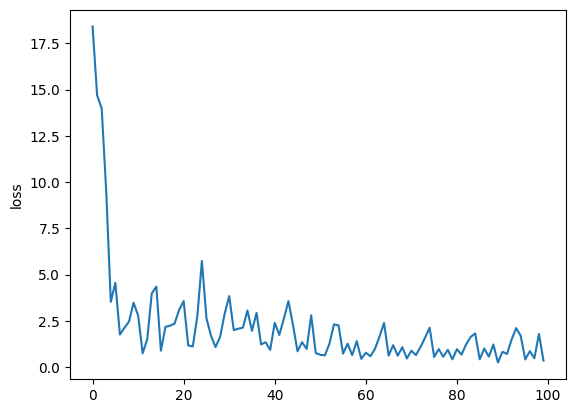

In [61]:
import matplotlib.pyplot as plt

plt.plot(list_o_loss)
# plt.ylim([0, 10])
plt.ylabel('loss')
plt.show()

In [62]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir gs://rec-bandits-v2-hybrid-vertex-bucket/02-big-local-bandits-rec-bandits-v2/run-20240301-042649/logs (started 6 days, 7:42:06 ago; pid 3837675)
  - port 6006: logdir gs://rec-bandits-v2-hybrid-vertex-bucket/02x-new-data-loading-v3/run-20240307-012852/logs (started 10:48:28 ago; pid 1590886)
  - port 6006: logdir gs://rec-bandits-v2-hybrid-vertex-bucket/02b-deep-bandits-rec-bandits-v2/run-20240214-180454/logs (started 21 days, 17:57:58 ago; pid 3029265)


In [63]:
# %load_ext tensorboard
%reload_ext tensorboard

In [64]:
%tensorboard --logdir=$LOG_DIR

In [30]:
# !kill 1590886

/bin/bash: line 1: kill: (1590886) - No such process


**Finished**